Классификация рукописных чисел полносвязной сетью

In [0]:
import torch
import random
import numpy as np

#инициализация random seed
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
#результаты не будет воспроизводимы внутри одного ноутбука
#ноутбук надо перезапустить и проделать все ячейки сверху вниз

In [0]:
#MNIST - датасет для классификации изображений
import torchvision.datasets
#качаем трейн и тест
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [39]:
#отдельно картинки, отдельно лейблы
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [40]:
#смотрим типы
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [0]:
#преобразуем данные в дробные числа
X_train = X_train.float()
X_test = X_test.float()

In [42]:
#смотрим размерность
#X - многомерный тензор (обозначаем большой буквой X)
#60000 и 10000 изображений, картинки размером 28*28
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [43]:
#лейблы - одномерные тензоры (обозначаем маленькой буквой y)
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

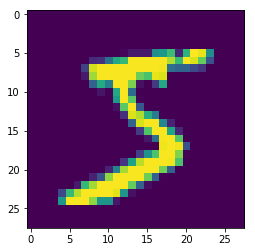

tensor(5)


In [44]:
#рисуем картинку
#импортируем библиотеку для графиков
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])
#видим цифру 5, ей соответствует лейбл 5

---------------------------------------


Ответ на вопрос

In [0]:
x=X_train

In [46]:
x.reshape(len(x[1]), len(x), len(x[2])).shape
#x.reshape(-1,14,32,7).shape
#x.reshape(-1,1,1).shape
#x.reshape(-1,6000).shape
#x.reshape(-1).shape
#x.reshape(-1,9).shape

torch.Size([28, 60000, 28])

---------------------------------

In [0]:
#каждая картинка описывается 2-мерных тензором
#растянем его в один вектор - теряется информация о близости/удаленности пикселей
#ф-я reshape: если задана размерность -1, значит "все, что осталось" (у нас первая размерность не изменяется)
#             если задана новая размерность, значит она применяется
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [0]:
#описываем нейросеть
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
#создаем нейронную сеть
mnist_net = MNISTNet(20)

In [49]:
#проверяем, видит ли торч GPU
torch.cuda.is_available()

True

In [50]:
#смотрим, занята ли видеокарта вычислениями
#констольная команда: чтобы запустить через колаб, ставим ! в начале
!nvidia-smi

Fri Jul  5 11:35:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |    905MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [51]:
#кроссплатформенный код
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#перкладываем нейросеть (ее парметры) на видеокарту
#используем метод .to(device)
mnist_net = mnist_net.to(device)

#проверяем, переложилась ли нейросеть на видеокарту: выводим на экран параметры
#если видим "device='cuda:0'", значит переложилась
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0085,  0.0223, -0.0324,  ..., -0.0296,  0.0182, -0.0296],
         [ 0.0112,  0.0016,  0.0017,  ..., -0.0132, -0.0219, -0.0235],
         [ 0.0184, -0.0159,  0.0055,  ..., -0.0004, -0.0215, -0.0144]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-0.0016,  0.0012,  0.0225, -0.0180, -0.0320,  0.0338,  0.0183,  0.0087,
         -0.0070, -0.0191, -0.0025,  0.0317, -0.0299,  0.0216, -0.0253,  0.0099,
          0.0235,  0.0013, -0.0004,  0.0116], device='cuda:0',
        requires_grad=True), Parameter containing:
 tensor([[-0.0631,  0.0384,  0.1812,  0.0456, -0.1603, -0.2221,  0.1136, -0.2145,
           0.1861, -0.1722, -0.2138,  0.1888, -0.0780, -0.1694,  0.1796, -0.1333,
           0.0685, -0.0729, 

In [0]:
#кросс-энтропия - лосс, который используется в классификации
loss = torch.nn.CrossEntropyLoss()
#оптимизатор Adam
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [58]:
#будем делить на батчи: трейн большой и может не поместиться на видеокарту, так процесс обучения происходит быстрее
#размер батча
batch_size = 100

#будем сохранять в списки значения accuracy и loss на тесте, чтобы потом построить график
test_accuracy_history = []
test_loss_history = []

#перекладываем весь тест на видеокарту
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(200):
  #перемешиваем датасет
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        #выделяем участки, перекладаваем их по отдельности на видеокарту
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        #делаем предсказание
        preds = mnist_net.forward(X_batch) 
        #счиатем лосс
        loss_value = loss(preds, y_batch)
        #счиатем градиенты
        loss_value.backward()
        
        #делаем шаг
        optimizer.step()

    #контроль качества: делаем предсказание на тестовом датасете
    #предполагаем, что он не очень большой, поэтому не делим на батчи
    test_preds = mnist_net.forward(X_test)
    #сохраняем знаечние в список
    test_loss_history.append(loss(test_preds, y_test))
    
    #считаем долю правильных ответов - accuracy
    #даже если выходы не проходят через софтмакс, мы можем сказать, что
    #нейросеть предсказывает тот класс, у которого максимальное значение на выходе
    #сравниваем номер этого выхода с лейблом
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    #сохраняем знаечние в список
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9042, device='cuda:0')
tensor(0.9084, device='cuda:0')
tensor(0.9129, device='cuda:0')
tensor(0.9110, device='cuda:0')
tensor(0.9195, device='cuda:0')
tensor(0.9168, device='cuda:0')
tensor(0.9140, device='cuda:0')
tensor(0.9133, device='cuda:0')
tensor(0.9158, device='cuda:0')
tensor(0.9155, device='cuda:0')
tensor(0.9131, device='cuda:0')
tensor(0.9178, device='cuda:0')
tensor(0.9130, device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(0.9211, device='cuda:0')
tensor(0.9195, device='cuda:0')
tensor(0.9156, device='cuda:0')
tensor(0.9171, device='cuda:0')
tensor(0.9065, device='cuda:0')
tensor(0.9108, device='cuda:0')
tensor(0.9176, device='cuda:0')
tensor(0.9071, device='cuda:0')
tensor(0.9139, device='cuda:0')
tensor(0.9161, device='cuda:0')
tensor(0.9232, device='cuda:0')
tensor(0.9205, device='cuda:0')
tensor(0.9195, device='cuda:0')
tensor(0.9166, device='cuda:0')
tensor(0.9175, device='cuda:0')
tensor(0.9192, device='cuda:0')
tensor(0.9127, device='cuda:0')
tensor(0

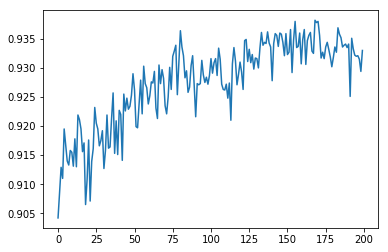

In [59]:
#выводим графики
#колебания в лоссе обычно меньше, чем колебания в accuracy, потому что
#accuracy - это округленное -> более дискретное значение
#можно сравнить графики по трейну и по тесту: если на трейне качество улучшается, а 
#на тесте нет, то это переобучение. Можно уменьшить кол-во параметров нейронной сети,
#кол-во слоев и их размеры
plt.plot(test_accuracy_history)

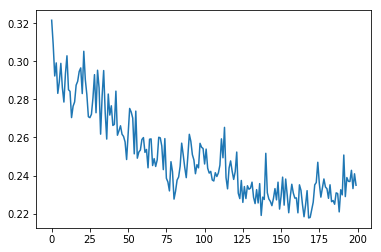

In [60]:
plt.plot(test_loss_history);

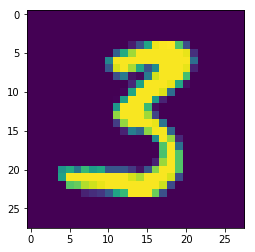

tensor(3)
4242


In [64]:
#X_test[0]
#y_test[0]
num = random.randint(0, 10000)
X_test = X_test.to('cpu')
y_test = y_test.to('cpu')
X_test = X_test.reshape([-1, 28, 28])
import matplotlib.pyplot as plt
plt.imshow(X_test[num])
plt.show()
print(y_test[num])
print(num)

In [65]:

X_test = X_test.reshape([-1, 28*28])
X_test = X_test.to(device)
y_test = y_test.to(device)
test_preds_1 = mnist_net.forward(X_test[num])
#сохраняем знаечние в список
#test_loss_history.append(loss(test_preds, y_test))
print(test_preds_1.argmax(dim=-1))
accuracy = (test_preds_1.argmax(dim=-1) == y_test[num]).float().mean()
#сохраняем знаечние в список
#test_accuracy_history.append(accuracy)
print(accuracy)

tensor(3, device='cuda:0')
tensor(1., device='cuda:0')
